# Spiral Autoencoder

This notebooks takes on training four different autoencoders - one for each spiral class.

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
from pathlib import Path

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence
import torch.optim as optim

import matplotlib.pyplot as plt

In [2]:
def remove_end_line(x, y, tol=1e-6):
    x = np.asarray(x)
    y = np.asarray(y)
    
    if len(x) < 3:
        return x, y
    
    last_point = np.array([x[-1], y[-1]])
    second_last_point = np.array([x[-2], y[-2]])
    line_vec = last_point - second_last_point
    
    for i in range(len(x) - 2, 0, -1):
        point = np.array([x[i], y[i]])
        vec = point - second_last_point
        cross = line_vec[0] * vec[1] - line_vec[1] * vec[0]
        if abs(cross) > tol:
            return x[:i+1], y[:i+1]
    
    return x, y

def resample_trajectory(r, theta):
    """
    Resample the trajectory defined by (r, theta) to new_theta values using linear interpolation.
    
    Parameters:
    - r: array-like, original radius values
    - theta: array-like, original theta values
    
    Returns:
    - new_r: array-like, interpolated radius values corresponding to new_theta
    """
    max_theta = theta[-1]
    steps_per_rotation = 100
    theta_linespace = np.linspace(0, max_theta, int(steps_per_rotation * (max_theta // (2 * np.pi))))
    
    r = np.asarray(r)
    theta = np.asarray(theta)
    
    new_r = np.interp(theta_linespace, theta, r)
    return new_r, theta_linespace

def plot_segmented_spiral(
    gen_theta,
    gen_r,
    num_segments=10,
    num_points=500,
    colors=None,
    figsize=(12, 6),
    plot_title=None,
    axes=None,
    original_data=None,
):
    """
    Generates and plots a spiral with segments of different colors.

    Parameters:
    - num_segments (int): The number of colored segments to divide the plot into.
    - num_points (int): The total number of points to generate for the spiral. Default is 500.
    - theta_end (int): The number of full rotations (2*pi) for the spiral. Default is 10.
    - noise_range (tuple): A tuple (min, max) for adding random noise to the radius.
                           Default is (-10, 10).
    - colors (list or None): A list of colors to use for the segments. If None,
                             Matplotlib's default color cycle will be used.
    - figsize (tuple): A tuple (width, height) for the figure size. Default is (12, 6).
    - plot_title (str or None): Title for the entire plot. If None, 'Spiral Generation with {num_segments} Segments' is set.
    - axes (tuple or None): A tuple of Matplotlib axes to plot on. If None, new axes will be created.
    """
    
    points_per_segment = num_points // num_segments
    segments_theta = [
        gen_theta[i * points_per_segment : (i + 1) * points_per_segment + 1]
        for i in range(num_segments)
    ]
    segments_r = [
        gen_r[i * points_per_segment : (i + 1) * points_per_segment + 1]
        for i in range(num_segments)
    ]
    
    # Use default colors if none are provided
    if colors is None:
        cmap = plt.colormaps['tab20']
        colors = [cmap(i) for i in range(num_segments)]
    colors = [colors[i % len(colors)] for i in range(num_segments)]

    # 3. Create the plots
    if axes is None:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, gridspec_kw={'wspace': 0.2})
        ax2 = fig.add_subplot(1, 2, 2, projection='polar')
    else:
        ax1, ax2 = axes

    # Cartesian subplot (Radius vs Theta)
    for i in range(num_segments):
        ax1.plot(np.unwrap(segments_theta[i]), segments_r[i], color=colors[i])
        if original_data is not None:
            orig_theta, orig_r = original_data
            ax1.plot(np.unwrap(orig_theta), orig_r, color='gray', alpha=0.3, linestyle='--')
    
    ax1.set_title("Radius vs Theta")
    ax1.grid(True)
    
    
    theta_end = int(gen_theta[-1] / np.pi)
    tick_positions = np.linspace(0, theta_end * np.pi, theta_end + 1)
    tick_labels = [f'{i}π' for i in range(theta_end + 1)]
    
    ax1.set_xticks(tick_positions, tick_labels)
    ax1.set_xlabel("Theta (radians)")
    ax1.set_ylabel("Radius")

    # Polar subplot (Spiral)
    for i in range(num_segments):
        ax2.plot(segments_theta[i], segments_r[i], color=colors[i])
        if original_data is not None:
            orig_theta, orig_r = original_data
            ax2.plot(orig_theta, orig_r, color='gray', alpha=0.3, linestyle='--')
    
    ax2.set_title("Generated spiral")
    ax2.grid(False)
    ax2.axis('off')
    
    if plot_title:
        plt.suptitle(plot_title)
    else:
        plt.suptitle(f"Spiral Generation with {num_segments} Segments")
    
    if axes is None:
        plt.show()

    return ax1, ax2
    
def plot_losses(train_losses, val_losses=None, figsize=(8, 6)):
    plt.figure(figsize=figsize)
    plt.plot(train_losses, label='Training Loss')
    if val_losses is not None:
        plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

### Data preparation

In [3]:
class SpiralDataset(Dataset):
    def __init__(self, folder, preload=True):
        self.files = list(Path(folder).glob("*.csv"))
        self.preload = preload
        if preload:
            self.data = [pd.read_csv(f)[['r', 'theta']].values.astype('float32') for f in self.files]
        else:
            self.data = None

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        if self.preload:
            arr = self.data[idx]
        else:
            df = pd.read_csv(self.files[idx])
            arr = df[['r', 'theta']].values.astype('float32')
        return torch.tensor(arr)

FIXED_LEN = 600

def collate_pad_fixed(batch, fixed_len=FIXED_LEN):
    """
    Pads or truncates each spiral to a fixed length.
    Each batch element is a tensor of shape (seq_len, 2).
    Returns (padded_batch, lengths)
    """
    new_batch = []
    lengths = []
    
    for x in batch:
        seq_len = x.size(0)
        lengths.append(min(seq_len, fixed_len))
        
        if seq_len < fixed_len:
            # pad with zeros
            pad = torch.zeros(fixed_len - seq_len, 2, dtype=x.dtype)
            new_x = torch.cat([x, pad], dim=0)
        else:
            # truncate
            new_x = x[:fixed_len]
        
        new_batch.append(new_x)
    
    padded_batch = torch.stack(new_batch, dim=0)  # (B, fixed_len, 2)
    lengths = torch.tensor(lengths, dtype=torch.int64)
    
    return padded_batch, lengths

### Autoencoder class

In [4]:
class SpiralAutoencoder(nn.Module):
    def __init__(self, input_len, latent_dim=16, hidden_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_len, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_len)
        )
    
    def forward(self, x):
        # x: (B, T, 2)
        B, T, D = x.size()
        x_flat = x.view(B, T*D)        # flatten spiral
        latent = self.encoder(x_flat)  # single vector per spiral
        out_flat = self.decoder(latent)
        out = out_flat.view(B, T, D)
        return out, latent

In [5]:
class SpiralRadiusAutoencoder(nn.Module):
    def __init__(self, input_len, latent_dim=16, hidden_dim=128):
        super().__init__()
        input_len = input_len//2
        self.encoder = nn.Sequential(
            nn.Linear(input_len, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_len)
        )
    
    def forward(self, x):
        # x: (B, T, 2)
        B, T, D = x.size()
        r = x[:, :, 0]          # (B, T) -> radius
        theta = x[:, :, 1]      # keep as is

        latent = self.encoder(r)         # encode only radius
        r_recon = self.decoder(latent)   # decode radius

        out = torch.stack([r_recon, theta], dim=-1)  # combine radius + original theta
        return out, latent

In [6]:
class SpiralRadiusAutoencoder2(nn.Module):
    def __init__(self, input_len, latent_dim=16, hidden_dim=128, hidden_dim2=64):
        super().__init__()
        input_len = input_len//2
        self.encoder = nn.Sequential(
            nn.Linear(input_len, hidden_dim),
            nn.LogSigmoid(),
            nn.Linear(hidden_dim, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_len)
        )
    
    def forward(self, x):
        # x: (B, T, 2)
        B, T, D = x.size()
        r = x[:, :, 0]          # (B, T) -> radius
        theta = x[:, :, 1]      # keep as is

        latent = self.encoder(r)         # encode only radius
        r_recon = self.decoder(latent)   # decode radius

        out = torch.stack([r_recon, theta], dim=-1)  # combine radius + original theta
        return out, latent

### Training

In [7]:
def masked_mse_loss_flat(reconstructed, target, lengths):
    """
    Computes MSE loss ignoring padded elements for flattened spirals.

    reconstructed: (B, T*D)
    target: (B, T*D)
    lengths: (B,)  # number of valid points per spiral
    """
    B, TD = target.size()
    D = 2  # r and theta
    T = TD // D

    # create mask for valid time steps
    mask = torch.arange(T, device=target.device).unsqueeze(0) < lengths.unsqueeze(1)  # (B, T)
    mask = mask.repeat_interleave(D, dim=1)  # (B, T*D)

    diff = (reconstructed - target) ** 2
    diff = diff * mask
    loss = diff.sum() / mask.sum()
    return loss

def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0.0
    for batch_data, lengths in dataloader:
        batch_data = batch_data.to(device)
        lengths = lengths.to(device)
        
        B, T, D = batch_data.size()
        
        optimizer.zero_grad()
        reconstructed, _ = model(batch_data)
        reconstructed_flat = reconstructed.view(B, T*D)
        batch_flat = batch_data.view(B, T*D)
        loss = masked_mse_loss_flat(reconstructed_flat, batch_flat, lengths)
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(batch_data)
    return total_loss / len(dataloader.dataset)

def train_model(
    model,
    train_loader,
    val_loader,
    device,
    num_epochs=50,
    learning_rate=1e-3,
    weight_decay=0.0,
    verbose=False
):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        train_loss = train_epoch(model, train_loader, optimizer, device)
        train_losses.append(train_loss)
        
        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            if (epoch+1) % 5 == 0 and verbose: print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        else:
            if (epoch+1) % 5 == 0 and verbose: print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")
    
    return train_losses, val_losses

In [8]:
@torch.no_grad()
def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch_data, lengths in dataloader:
            batch_data = batch_data.to(device)
            lengths = lengths.to(device)
            reconstructed, _ = model(batch_data)
            B, T, D = batch_data.size()
            loss = masked_mse_loss_flat(
                reconstructed.view(B, T*D),
                batch_data.view(B, T*D),
                lengths
            )
            total_loss += loss.item() * len(batch_data)
    return total_loss / len(dataloader.dataset)

Starting training...
Epoch 5/200, Train Loss: 10.3432, Val Loss: 11.2221
Epoch 10/200, Train Loss: 9.6698, Val Loss: 10.4283
Epoch 15/200, Train Loss: 2.4971, Val Loss: 2.5124
Epoch 20/200, Train Loss: 1.8995, Val Loss: 2.0703
Epoch 25/200, Train Loss: 1.7507, Val Loss: 1.9032
Epoch 30/200, Train Loss: 1.6509, Val Loss: 1.8485
Epoch 35/200, Train Loss: 1.5571, Val Loss: 1.6953
Epoch 40/200, Train Loss: 1.3965, Val Loss: 1.5557
Epoch 45/200, Train Loss: 1.1651, Val Loss: 1.2775
Epoch 50/200, Train Loss: 0.9719, Val Loss: 1.0397
Epoch 55/200, Train Loss: 0.7988, Val Loss: 0.8516
Epoch 60/200, Train Loss: 0.7153, Val Loss: 0.7472
Epoch 65/200, Train Loss: 0.6658, Val Loss: 0.6957
Epoch 70/200, Train Loss: 0.6383, Val Loss: 0.6725
Epoch 75/200, Train Loss: 0.6167, Val Loss: 0.6361
Epoch 80/200, Train Loss: 0.6023, Val Loss: 0.6269
Epoch 85/200, Train Loss: 0.5870, Val Loss: 0.6134
Epoch 90/200, Train Loss: 0.5596, Val Loss: 0.5873
Epoch 95/200, Train Loss: 0.5390, Val Loss: 0.5825
Epoch 10

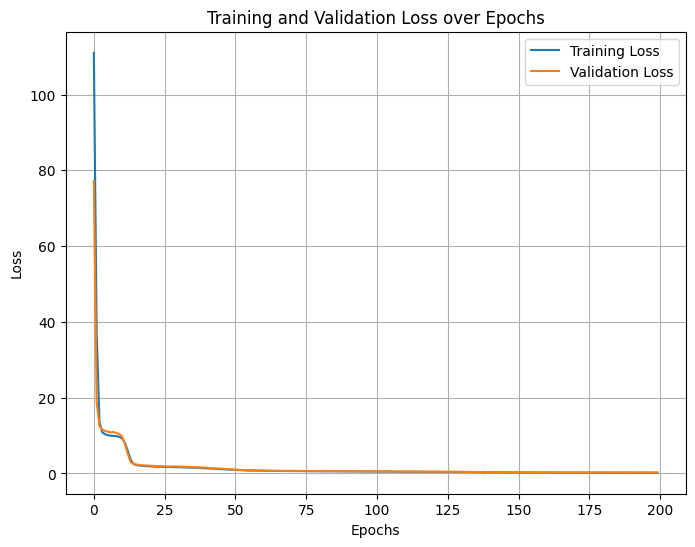

In [9]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-6
NUM_EPOCHS = 200
BATCH_SIZE = 32
HIDDEN_DIM = 512
LATENT_DIM = 32

model = SpiralRadiusAutoencoder2(input_len=FIXED_LEN*2, hidden_dim=HIDDEN_DIM, hidden_dim2=256, latent_dim=LATENT_DIM).to(DEVICE)

# Dataset
data_folder = "./syn_data/tight/"
full_dataset = SpiralDataset(data_folder)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_pad_fixed)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_pad_fixed)

# Training loop
print("Starting training...")
train_losses, val_losses = train_model(model, train_loader, val_loader, DEVICE, num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY, verbose=True)
print("Training complete.")

# Plot losses
plot_losses(train_losses, val_losses)

### Parameter optimization (grid search)

In [ ]:
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]
weight_decays = [0.0, 1e-5, 1e-4]
hidden_dims = [128, 256]
batch_sizes = [16, 32, 64]
# latent_dims = [16, 32]

grid = {
    'learning_rate': learning_rates,
    'weight_decay': weight_decays,
    'hidden_dim': hidden_dims,
    'batch_size': batch_sizes
}

import itertools
def generate_hyperparameter_combinations(grid):
    keys = grid.keys()
    values = grid.values()
    for combination in itertools.product(*values):
        yield dict(zip(keys, combination))
combinations = list(generate_hyperparameter_combinations(grid))

min_val_loss = float('inf')
best_hyperparams = None

print(f"Total hyperparameter combinations to try: {len(combinations)}")
for i, combo in enumerate(combinations):
    print(f"Combination {i+1}/{len(combinations)}: {combo}")
    
    model = SpiralRadiusAutoencoder(input_len=FIXED_LEN*2, hidden_dim=combo['hidden_dim'], latent_dim=128).to(DEVICE)
    train_loader = DataLoader(train_dataset, batch_size=combo['batch_size'], shuffle=True, collate_fn=collate_pad_fixed)
    val_loader = DataLoader(val_dataset, batch_size=combo['batch_size'], shuffle=False, collate_fn=collate_pad_fixed)
    train_losses, val_losses = train_model(
        model,
        train_loader,
        val_loader,
        DEVICE,
        num_epochs=NUM_EPOCHS,
        learning_rate=combo['learning_rate'],
        weight_decay=combo['weight_decay'],
        verbose=False
    )
    final_val_loss = val_losses[-1]
    if final_val_loss < min_val_loss:
        min_val_loss = final_val_loss
        best_hyperparams = combo
        print(f"New best hyperparameters found: {best_hyperparams} with Val Loss: {min_val_loss:.4f}")
    
print(f"Best hyperparameters: {best_hyperparams} with Val Loss: {min_val_loss:.4f}")

Total hyperparameter combinations to try: 72
Combination 1/72: {'learning_rate': 0.01, 'weight_decay': 0.0, 'hidden_dim': 128, 'batch_size': 16}
New best hyperparameters found: {'learning_rate': 0.01, 'weight_decay': 0.0, 'hidden_dim': 128, 'batch_size': 16} with Val Loss: 31.5763
Combination 2/72: {'learning_rate': 0.01, 'weight_decay': 0.0, 'hidden_dim': 128, 'batch_size': 32}
Combination 3/72: {'learning_rate': 0.01, 'weight_decay': 0.0, 'hidden_dim': 128, 'batch_size': 64}
New best hyperparameters found: {'learning_rate': 0.01, 'weight_decay': 0.0, 'hidden_dim': 128, 'batch_size': 64} with Val Loss: 1.6936
Combination 4/72: {'learning_rate': 0.01, 'weight_decay': 0.0, 'hidden_dim': 256, 'batch_size': 16}
Combination 5/72: {'learning_rate': 0.01, 'weight_decay': 0.0, 'hidden_dim': 256, 'batch_size': 32}
Combination 6/72: {'learning_rate': 0.01, 'weight_decay': 0.0, 'hidden_dim': 256, 'batch_size': 64}
Combination 7/72: {'learning_rate': 0.01, 'weight_decay': 1e-05, 'hidden_dim': 128

In [ ]:
best_model = SpiralRadiusAutoencoder(input_len=FIXED_LEN*2, hidden_dim=best_hyperparams['hidden_dim'], latent_dim=LATENT_DIM).to(DEVICE)
train_loader = DataLoader(train_dataset, batch_size=best_hyperparams['batch_size'], shuffle=True, collate_fn=collate_pad_fixed)
val_loader = DataLoader(val_dataset, batch_size=best_hyperparams['batch_size'], shuffle=False, collate_fn=collate_pad_fixed)
train_losses, val_losses = train_model(
    best_model,
    train_loader,
    val_loader,
    DEVICE,
    num_epochs=NUM_EPOCHS,
    learning_rate=best_hyperparams['learning_rate'],
    weight_decay=best_hyperparams['weight_decay'],
    verbose=True
)

torch.save({
    'input_len': FIXED_LEN*2,
    'latent_dim': LATENT_DIM,
    'hidden_dim': best_hyperparams['hidden_dim'],
    'state_dict': best_model.state_dict()
}, "spiky_spiral_autoencoder_fullinfo.pt")

Epoch 5/200, Train Loss: 1.7496, Val Loss: 2.0176
Epoch 10/200, Train Loss: 1.5660, Val Loss: 1.5418
Epoch 15/200, Train Loss: 1.5438, Val Loss: 1.5266
Epoch 20/200, Train Loss: 1.5407, Val Loss: 1.5199
Epoch 25/200, Train Loss: 1.5052, Val Loss: 1.4892
Epoch 30/200, Train Loss: 1.4501, Val Loss: 1.4500
Epoch 35/200, Train Loss: 1.4554, Val Loss: 1.4416
Epoch 40/200, Train Loss: 1.4345, Val Loss: 1.4997
Epoch 45/200, Train Loss: 1.4411, Val Loss: 1.4583
Epoch 50/200, Train Loss: 1.4299, Val Loss: 1.4647
Epoch 55/200, Train Loss: 1.4347, Val Loss: 1.4462
Epoch 60/200, Train Loss: 1.4274, Val Loss: 1.4390
Epoch 65/200, Train Loss: 1.4185, Val Loss: 1.4459
Epoch 70/200, Train Loss: 1.4186, Val Loss: 1.4473
Epoch 75/200, Train Loss: 1.4568, Val Loss: 1.4548
Epoch 80/200, Train Loss: 1.4567, Val Loss: 1.4506
Epoch 85/200, Train Loss: 1.4673, Val Loss: 1.4575
Epoch 90/200, Train Loss: 1.4036, Val Loss: 1.4328
Epoch 95/200, Train Loss: 1.4066, Val Loss: 1.4916
Epoch 100/200, Train Loss: 1.438

### Results

In [10]:
def plot_spiral_reconstruction(model, dataloader, device, num_samples=5, plot=True):
    model.eval()
    with torch.no_grad():
        for batch_data, lengths in dataloader:  # lengths still come from collate
            batch_data = batch_data.to(device)
            reconstructed, _ = model(batch_data)  # unpack tuple
            break  # only take first batch

    batch_data = batch_data.cpu()
    reconstructed = reconstructed.cpu()
    lengths = lengths.cpu()

    num_samples = min(num_samples, batch_data.size(0))
    if plot:
        _, axs = plt.subplots(1, num_samples, figsize=(4*num_samples, 4), subplot_kw={'projection':'polar'})

        if num_samples == 1:
            axs = [axs]

    recon_rs = []
    recon_thetas = []
    for i in range(num_samples):
        seq_len = lengths[i]  # trim to original length
        orig_r = batch_data[i, :seq_len, 0]
        orig_theta = batch_data[i, :seq_len, 1]

        recon_r = reconstructed[i, :seq_len, 0]
        recon_theta = reconstructed[i, :seq_len, 1]
        recon_rs.append(recon_r)
        recon_thetas.append(recon_theta)
        
        B, T, D = batch_data.size()
        loss = masked_mse_loss_flat(
            reconstructed.view(B, T*D),
            batch_data.view(B, T*D),
            lengths
        ).item()

        if plot:
            ax = axs[i]
            ax.plot(orig_theta, orig_r, color='grey', lw=2)
            ax.plot(recon_theta, recon_r, color='blue', lw=2)
            ax.axis('off')
            ax.set_title(f"Sample {i+1}, MSE: {loss:.4f}")

    # optional legend
    if plot:
        axs[0].plot([], [], color='grey', lw=2, label='Original')
        axs[0].plot([], [], color='blue', lw=2, label='Reconstruction')
        axs[0].legend(loc='upper right')

        plt.tight_layout()
        plt.show()
    
    return recon_rs, recon_thetas

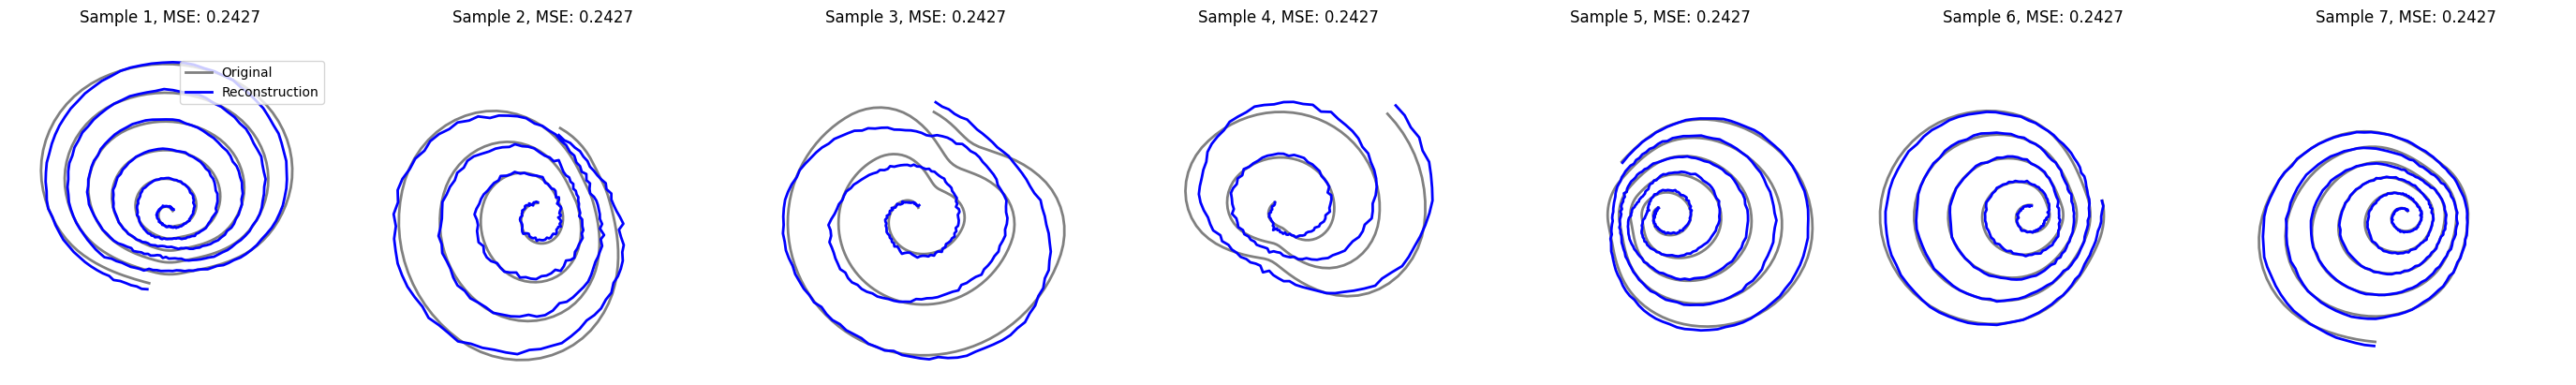

In [11]:
# data_folder = "./syn_data/tight/"
# full_dataset = SpiralDataset(data_folder)

# train_size = int(0.8 * len(full_dataset))
# val_size = len(full_dataset) - train_size
# train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
# train_loader = DataLoader(train_dataset, batch_size=combo['batch_size'], shuffle=True, collate_fn=collate_pad_fixed)
# val_loader = DataLoader(val_dataset, batch_size=combo['batch_size'], shuffle=False, collate_fn=collate_pad_fixed)
rs, thetas = plot_spiral_reconstruction(model, val_loader, DEVICE, num_samples=7)

In [13]:
def resample_by_nearest_linear(r, theta, num_points=None, step=None, allow_extrapolate=True):
    """
    Resample polar trajectory (r, theta) by interpolating r at new theta grid.
    For each new theta value, find the two nearest original theta samples and linearly
    interpolate the radius between them.

    Args:
        r (array-like): radius values (length N)
        theta (array-like): angle values in radians (length N)
        num_points (int or None): number of output points (preferred). If None, `step` must be provided.
        step (float or None): angular step (radians) for new theta grid if num_points is None.
        allow_extrapolate (bool): if True, linearly extrapolate beyond original theta range;
                                  if False, clamp to endpoints.

    Returns:
        new_r (np.ndarray): interpolated radius values (length M)
        new_theta (np.ndarray): output theta grid (length M)
    """
    r = np.asarray(r, dtype=float)
    theta = np.asarray(theta, dtype=float)
    if r.shape[0] != theta.shape[0]:
        raise ValueError("r and theta must have same length")

    # 1) Unwrap so theta is monotonic
    theta_unwrapped = np.unwrap(theta)

    # 2) Sort by theta (important if input isn't strictly ordered)
    order = np.argsort(theta_unwrapped)
    theta_sorted = theta_unwrapped[order]
    r_sorted = r[order]

    # 3) Remove duplicate theta values (keep first of duplicates)
    #    (searchsorted / interpolation needs strictly increasing x)
    unique_theta, unique_idx = np.unique(theta_sorted, return_index=True)
    theta_sorted = theta_sorted[unique_idx]
    r_sorted = r_sorted[unique_idx]

    if len(theta_sorted) < 2:
        raise ValueError("Need at least two unique theta values to interpolate")

    # 4) Build new theta grid
    theta_min, theta_max = theta_sorted[0], theta_sorted[-1]
    if num_points is not None:
        new_theta = np.linspace(theta_min, theta_max, num_points)
    elif step is not None:
        if step <= 0:
            raise ValueError("step must be positive")
        new_theta = np.arange(theta_min, theta_max + 1e-12, step)
    else:
        raise ValueError("Either num_points or step must be provided")

    # print(new_theta)
    
    # 5) Interpolate using nearest neighbors (linear interpolation between surrounding points)
    # Use searchsorted to find right-hand index for each new_theta
    idx_right = np.searchsorted(theta_sorted, new_theta, side='right')
    # idx_right in [0 .. len(theta_sorted)], idx_left = idx_right - 1

    left_idx = idx_right - 1
    right_idx = idx_right

    # Clip indices to valid range for interpolation/extrapolation
    left_idx_clipped = np.clip(left_idx, 0, len(theta_sorted) - 1)
    right_idx_clipped = np.clip(right_idx, 0, len(theta_sorted) - 1)

    theta_left = theta_sorted[left_idx_clipped]
    theta_right = theta_sorted[right_idx_clipped]
    r_left = r_sorted[left_idx_clipped]
    r_right = r_sorted[right_idx_clipped]

    # # Compute weights for linear interpolation.
    # # If theta_right == theta_left (shouldn't happen after uniqueness), avoid div by zero
    # denom = (theta_right - theta_left)
    # # For denom == 0, set weight to 0.0 (so we pick r_left)
    # safe_denom = np.where(np.abs(denom) < 1e-12, 1.0, denom)
    # w_right = (new_theta - theta_left) / safe_denom
    # w_right = np.clip(w_right, 0.0, 1.0)  # clamp to [0,1] for stable interpolation
    # w_left = 1.0 - w_right

    # new_r = w_left * r_left + w_right * r_right
    new_r = r_left

    # 6) Handle extrapolation if allow_extrapolate==False: clamp to endpoints
    if not allow_extrapolate:
        # If new_theta < theta_min, set r to r_sorted[0]; if > theta_max, set to r_sorted[-1]
        new_r = np.where(new_theta < theta_min, r_sorted[0], new_r)
        new_r = np.where(new_theta > theta_max, r_sorted[-1], new_r)
    else:
        # If allow_extrapolate True, for positions where left==right (i.e., outside range),
        # we already clipped indices; the linear formula does a nearest extrapolation.
        pass

    return new_r, new_theta

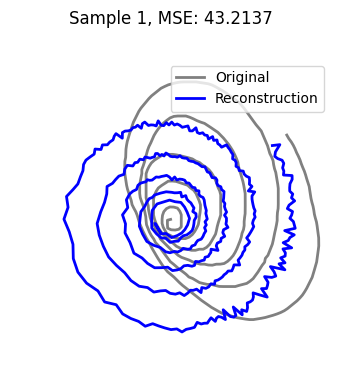

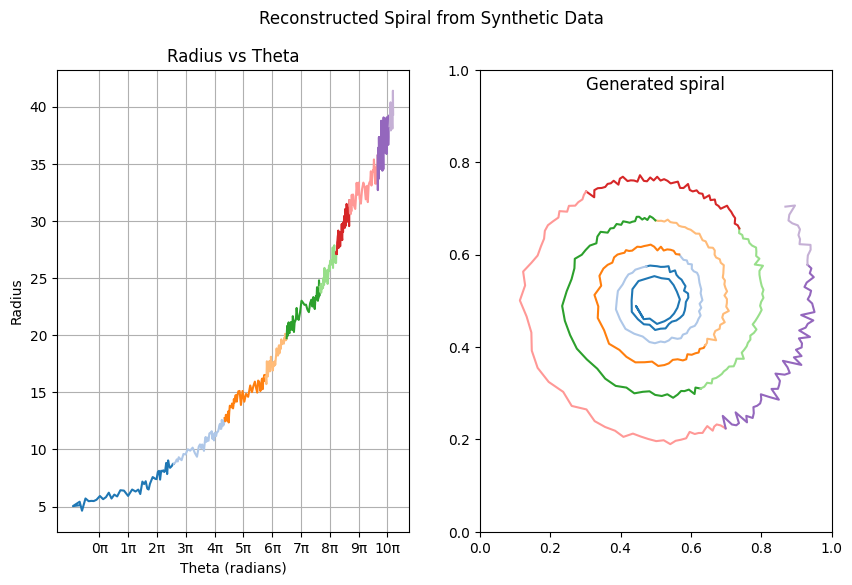

(<Axes: title={'center': 'Radius vs Theta'}, xlabel='Theta (radians)', ylabel='Radius'>,
 <PolarAxes: title={'center': 'Generated spiral'}>)

In [15]:
df = pd.read_csv("drawings/long/l_all_dft_reconstructed_500.csv")
grouped = df.groupby("original_file")
sp_name, sp_df = list(grouped)[9]  # pick one spiral

sp_x = sp_df['x'] - sp_df['x'].iloc[0]
sp_y = sp_df['y'] - sp_df['y'].iloc[0]
sp_x, sp_y = remove_end_line(sp_x, sp_y, tol=1e-6)
sp_y = sp_y  # Invert y-axis if needed
sp_r = np.sqrt(sp_x**2 + sp_y**2)  # scale down
sp_theta = np.arctan2(sp_y, sp_x)
sp_theta = np.unwrap(sp_theta)

# new_sp_r, new_sp_theta = resample_trajectory(sp_r, sp_theta)
new_sp_r, new_sp_theta = resample_by_nearest_linear(sp_r, sp_theta, num_points=int(100 * (max(sp_theta) // (2 * np.pi))), allow_extrapolate=True)

temp_df1 = pd.DataFrame({'r': sp_r, 'theta': sp_theta}).to_csv("temp_results/temp_spiral1.csv", index=False)
# temp_df2 = pd.DataFrame({'r': new_sp_r, 'theta': new_sp_theta}).to_csv("temp_results/temp_spiral2.csv", index=False)

test_dataset = SpiralDataset("temp_results", preload=True)

test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_pad_fixed)
recon_rs, recon_thetas = plot_spiral_reconstruction(model, test_loader, DEVICE, num_samples=1)

plot_segmented_spiral(
    gen_theta=recon_thetas[0],
    gen_r=recon_rs[0],
    num_segments=10,
    figsize=(10,6),
    plot_title="Reconstructed Spiral from Synthetic Data",
)

# plot_segmented_spiral(
#     gen_theta=recon_thetas[1],
#     gen_r=recon_rs[1],
#     num_segments=10,
#     figsize=(10,6),
#     plot_title="Reconstructed Spiral from Synthetic Data"
# )

In [22]:
df_syn = pd.read_csv("drawings/nice_samples/spirala_spiky.csv")


r_syn, theta_syn = df_syn['r'].values, df_syn['theta'].values

theta_syn = np.unwrap(theta_syn)

temp_df = pd.DataFrame({'r': r_syn, 'theta': theta_syn})
temp_df.to_csv("temp_results/temp_spiral.csv", index=False)
test_dataset = SpiralDataset("temp_results", preload=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_pad_fixed)

recon_rs, recon_thetas = plot_spiral_reconstruction(model, test_loader, DEVICE, num_samples=1, plot=False)
plot_segmented_spiral(
    gen_theta=recon_thetas[0],
    gen_r=recon_rs[0],
    num_segments=10,
    figsize=(10,6),
    plot_title="Reconstructed Spiral from Synthetic Data"
)

KeyError: 'r'

### Evaluating trained models

In [23]:
checkpoint = torch.load("tight_spiral_autoencoder_fullinfo.pt")
loaded_model = SpiralRadiusAutoencoder(
    input_len=checkpoint['input_len'],
    latent_dim=checkpoint['latent_dim'],
    hidden_dim=checkpoint['hidden_dim']
)
loaded_model.load_state_dict(checkpoint['state_dict'])
loaded_model.eval()

SpiralRadiusAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=600, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=600, bias=True)
  )
)

In [24]:
# Function that resamples trajectory to have M evenly spaced points
def resample_trajectory(trajectory, M):
    N = len(trajectory)
    seg_len = path_length(trajectory) / M
    g = {0: trajectory[0]}
    i = 0
    k = 1
    alpha = 0.0
    beta = seg_len
    
    while (i < N) and (k < M):
        x0, y0 = trajectory[i]
        x1, y1 = trajectory[(i+1) % N]
        d = ((x1 - x0)**2 + (y1 - y0)**2)**0.5
        
        while (beta <= alpha + d) and (k < M):
            xk = x0 + (beta - alpha) * (x1 - x0) / d
            yk = y0 + (beta - alpha) * (y1 - y0) / d
            g[k] = (xk, yk)
            k += 1
            beta += seg_len
            
        alpha += d
        i += 1
        
    return g
    
# Function that computes the total length of the trajectory
def path_length(trajectory):
    N = len(trajectory)
    length = 0.0
    for i in range(0,N):
        x0, y0 = trajectory[i]
        x1, y1 = trajectory[(i+1) % N]
        length += ((x1 - x0)**2 + (y1 - y0)**2)**0.5
    return length

# Function that computes the Fourier Descriptor Transform
def fourier_descriptor_transform(g):
    N = len(g)
    z = np.array([complex(x, y) for x, y in g.values()])
    Z = np.fft.fft(z) / N
    return Z

# Function that computes the Inverse Fourier Descriptor Transform
def inverse_fourier_descriptor_transform(Z):
    N = len(Z)
    z = np.fft.ifft(Z * N)
    g_reconstructed = {m: (z[m].real, z[m].imag) for m in range(N)}
    return g_reconstructed

def get_descriptors(filepath, M=100):
    df = pd.read_csv(filepath)
    df.drop_duplicates(subset=['x', 'y'], keep='first', inplace=True)
    df['x'] = df['x'] - df['x'].iloc[0]
    df['y'] = df['y'] - df['y'].iloc[0]

    g = resample_trajectory(list(zip(df['x'], df['y'])), M)
    Z = fourier_descriptor_transform(g)
    return Z

def archimedas_spiral(theta_range, a0, granularity=500):
    theta = np.linspace(theta_range[0], theta_range[1], granularity)
    arch_x = a0*theta*np.cos(theta)
    arch_y = a0*theta*np.sin(theta)
    
    return (arch_x,arch_y)

def archimedas_descriptor(theta_range, a0, granularity=500):
    arch = archimedas_spiral(theta_range, a0, granularity)
    
    arch_traj = resample_trajectory([(x,y) for x,y in zip(arch[0],arch[1])],M)
    Z_archimedes = fourier_descriptor_transform(arch_traj)
    
    return Z_archimedes

def remove_end_line(x, y, tol=1e-6):
    x = np.asarray(x)
    y = np.asarray(y)
    
    if len(x) < 3:
        return x, y
    
    last_point = np.array([x[-1], y[-1]])
    second_last_point = np.array([x[-2], y[-2]])
    line_vec = last_point - second_last_point
    
    for i in range(len(x) - 2, 0, -1):
        point = np.array([x[i], y[i]])
        vec = point - second_last_point
        cross = line_vec[0] * vec[1] - line_vec[1] * vec[0]
        if abs(cross) > tol:
            return x[:i+1], y[:i+1]
    
    return x, y

def plot_segmented_spiral(
    gen_theta,
    gen_r,
    num_segments=10,
    num_points=500,
    colors=None,
    figsize=(12, 6),
    plot_title=None,
    axes=None
):
    """
    Generates and plots a spiral with segments of different colors.

    Parameters:
    - num_segments (int): The number of colored segments to divide the plot into.
    - num_points (int): The total number of points to generate for the spiral. Default is 500.
    - theta_end (int): The number of full rotations (2*pi) for the spiral. Default is 10.
    - noise_range (tuple): A tuple (min, max) for adding random noise to the radius.
                           Default is (-10, 10).
    - colors (list or None): A list of colors to use for the segments. If None,
                             Matplotlib's default color cycle will be used.
    - figsize (tuple): A tuple (width, height) for the figure size. Default is (12, 6).
    - plot_title (str or None): Title for the entire plot. If None, 'Spiral Generation with {num_segments} Segments' is set.
    - axes (tuple or None): A tuple of Matplotlib axes to plot on. If None, new axes will be created.
    """
    
    points_per_segment = num_points // num_segments
    segments_theta = [
        gen_theta[i * points_per_segment : (i + 1) * points_per_segment + 1]
        for i in range(num_segments)
    ]
    segments_r = [
        gen_r[i * points_per_segment : (i + 1) * points_per_segment + 1]
        for i in range(num_segments)
    ]
    
    # Use default colors if none are provided
    if colors is None:
        cmap = plt.colormaps['tab20']
        colors = [cmap(i) for i in range(num_segments)]
    colors = [colors[i % len(colors)] for i in range(num_segments)]

    # 3. Create the plots
    if axes is None:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, gridspec_kw={'wspace': 0.2})
        ax2 = fig.add_subplot(1, 2, 2, projection='polar')
    else:
        ax1, ax2 = axes

    # Cartesian subplot (Radius vs Theta)
    for i in range(num_segments):
        ax1.plot(np.unwrap(segments_theta[i]), segments_r[i], color=colors[i])
    
    ax1.set_title("Radius vs Theta")
    ax1.grid(True)
    
    
    theta_end = int(gen_theta[-1] / np.pi)
    tick_positions = np.linspace(0, theta_end * np.pi, theta_end + 1)
    tick_labels = [f'{i}π' for i in range(theta_end + 1)]
    
    ax1.set_xticks(tick_positions, tick_labels)
    ax1.set_xlabel("Theta (radians)")
    ax1.set_ylabel("Radius")

    # Polar subplot (Spiral)
    for i in range(num_segments):
        ax2.plot(segments_theta[i], segments_r[i], color=colors[i])
    
    ax2.set_title("Generated spiral")
    ax2.grid(False)
    ax2.axis('off')
    
    if plot_title:
        plt.suptitle(plot_title)
    else:
        plt.suptitle(f"Spiral Generation with {num_segments} Segments")
    
    if axes is None:
        plt.show()
    else: 
        return ax1, ax2

In [35]:
directory = "drawings/nice_samples/"
filename = "spirala_tight"
filepath = directory + filename + ".csv"

descriptors = get_descriptors(filepath, M=1000)
g_recon = np.array(list(inverse_fourier_descriptor_transform(descriptors).values()))
sp_x, sp_y = remove_end_line(g_recon[:,0], g_recon[:,1])
sp_y = -sp_y  # Invert y-axis if necessary
sp_r = np.sqrt(sp_x**2 + sp_y**2)
sp_theta = np.arctan2(sp_y, sp_x)
sp_theta = np.unwrap(sp_theta)

sp_resampled_r, sp_resampled_theta = resample_by_nearest_linear(sp_r, sp_theta, step=(2*np.pi/100), allow_extrapolate=False)

print(f"Original spiral points: {len(sp_r)}")

# plot_segmented_spiral(
#     gen_theta=sp_resampled_theta,
#     gen_r=sp_resampled_r,
#     num_segments=10,
#     figsize=(10,6),
#     plot_title="Original Spiral"
# )

temp_df = pd.DataFrame({'r': sp_resampled_r, 'theta': sp_resampled_theta})
temp_df.to_csv("temp_results/temp_spiral.csv", index=False)
test_dataset = SpiralDataset("temp_results", preload=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_pad_fixed)

recon_rs, recon_thetas = plot_spiral_reconstruction(loaded_model, test_loader, DEVICE, num_samples=1, plot=False)

print(f"Reconstructed spiral points: {len(recon_rs[0])}")

plot_segmented_spiral(
    gen_theta=recon_thetas[0][:-50],
    gen_r=recon_rs[0][:-50],
    num_segments=10,
    figsize=(10,6),
    plot_title="Reconstructed Spiral from Synthetic Data",
    original_data=(sp_resampled_theta, sp_resampled_r)
)

TypeError: 'int' object is not subscriptable

## Latent space visualization

In [12]:
def get_latent_vectors(model, dataloader, device):
    model.eval()
    latent_vectors = []
    with torch.no_grad():
        for batch_data, lengths in dataloader:
            batch_data = batch_data.to(device)
            _, latent = model(batch_data)
            latent_vectors.append(latent.cpu())
    latent_vectors = torch.cat(latent_vectors, dim=0)
    return latent_vectors

In [14]:
latent_vectors = get_latent_vectors(model, val_loader, DEVICE)

In [15]:
latent_vectors.shape

torch.Size([200, 32])